In [1]:
import torch
import torch.nn as nn
import torch_directml
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

from pathlib import Path
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import DataLoader
from model import mobilevig
from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from IPython.display import display, HTML, clear_output
from scipy.ndimage import gaussian_filter1d

c:\Ngoding\SKRIPSI FIX\GNN\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch_directml.device() if torch_directml.is_available() else 'cpu'

In [14]:
# Parameters
NUM_EPOCHS = 50
BATCH_SIZE = 7
NUM_WORKERS = 4
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0

In [15]:
# Paths
train_dir = Path("./dataset/train/")
test_dir = Path("./dataset/test/")

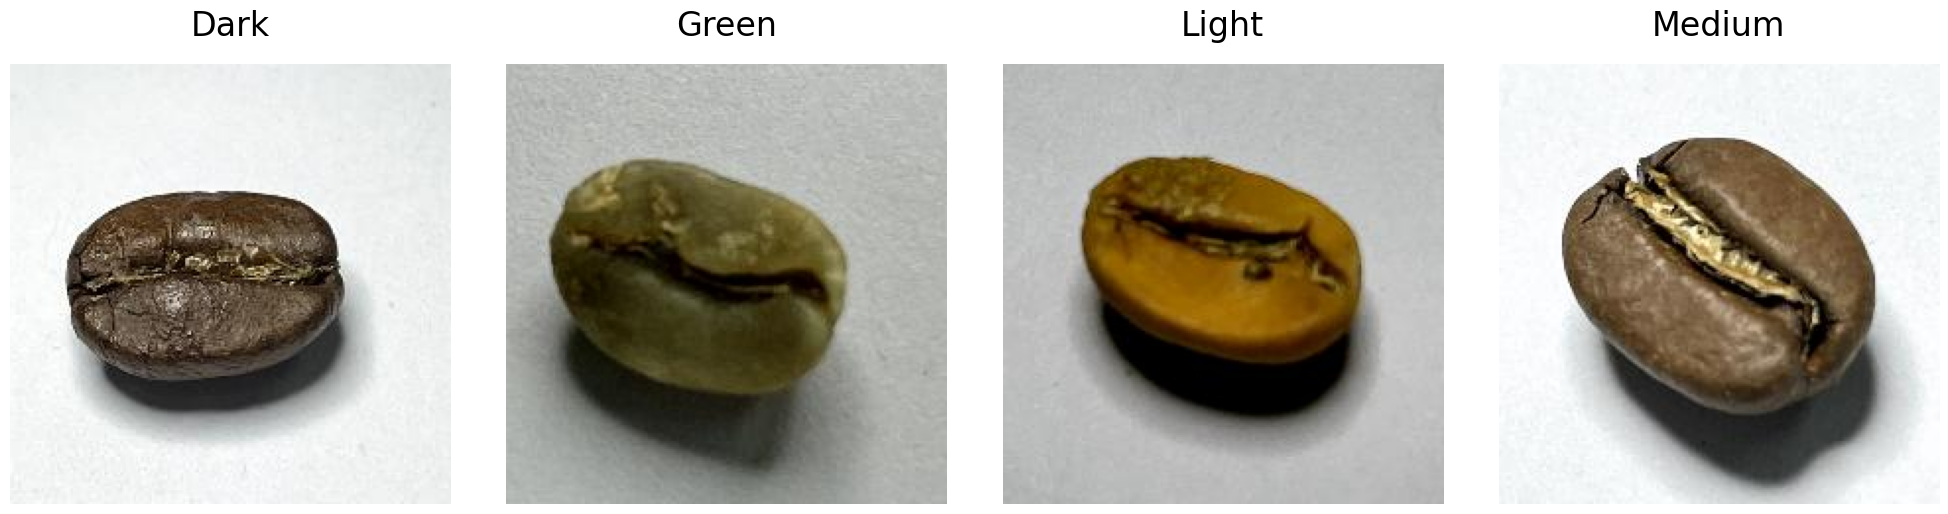

In [36]:
def visualize_image(train_dir, target_size=(224, 224)): 
    class_dir = [d for d in train_dir.iterdir() if d.is_dir()] 
    class_name = [d.name for d in class_dir] 
    fig, axs = plt.subplots(1, len(class_name), figsize=(len(class_name) * 5, 5)) 
    
    for ax, class_dir, class_name in zip(axs, class_dir, class_name): 
        image_file = list(class_dir.glob("*")) 
        if not image_file:  # Handle empty directories
            ax.axis("off")
            ax.set_title(f"No images in {class_name}", pad=20, fontsize=24)
            continue
        
        image_file2 = random.choice(image_file)  # Choose one file randomly
        image = Image.open(image_file2)         # Open the selected image
        image = image.resize(target_size) 
        
        ax.imshow(image) 
        ax.axis("off") 
        ax.set_title(class_name, pad=20, fontsize=24) 
    
    plt.tight_layout() 
    plt.show() 

visualize_image(train_dir)

In [16]:
# Transforms
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(str(train_dir), transform=train_transforms)
test_dataset = datasets.ImageFolder(str(test_dir), transform=test_transforms)

print("Class: ", train_dataset.classes)
print(f"Total images in train dataset: {len(train_dataset)}")
print(f"Total images in test dataset: {len(test_dataset)}")

Class:  ['Dark', 'Green', 'Light', 'Medium']
Total images in train dataset: 2153
Total images in test dataset: 238


In [17]:
# DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [96]:
# Model Setup
model = mobilevig.mobilevig_s(
    dropout=DROPOUT_RATE, 
    num_classes=len(train_dataset.classes)
    ).to(device)

In [97]:
# Optimizer and Loss Function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [98]:
# Learning Rate Scheduler
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=num_training_steps
)

In [99]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.01, use_accuracy=False):
        self.patience = patience
        self.min_delta = min_delta
        self.use_accuracy = use_accuracy
        self.counter = 0
        self.best_loss = float('inf')
        self.best_accuracy = 0.0
        self.early_stop = False

    def __call__(self, train_loss, test_loss, train_accuracy=None, test_accuracy=None):
        # Check if there is an improvement in the test loss
        if test_loss < self.best_loss - self.min_delta:
            self.best_loss = test_loss
            self.counter = 0
        else:
            self.counter += 1

        # Check if there is an improvement in the test accuracy (if use_accuracy is True)
        if self.use_accuracy and test_accuracy is not None:
            if test_accuracy > self.best_accuracy + self.min_delta:
                self.best_accuracy = test_accuracy
                self.counter = 0
            else:
                self.counter += 1

        # Check for overfitting based on loss
        if train_loss < test_loss - self.min_delta:
            self.counter += 1

        # Check for underfitting based on loss
        # if train_loss > test_loss + self.min_delta:
        #     self.counter += 1

        # Check for overfitting based on accuracy (if use_accuracy is True)
        if self.use_accuracy and train_accuracy is not None and test_accuracy is not None:
            if train_accuracy > test_accuracy + self.min_delta:
                self.counter += 1

        # # Check for underfitting based on accuracy (if use_accuracy is True)
        # if self.use_accuracy and train_accuracy is not None and test_accuracy is not None:
        #     if train_accuracy < test_accuracy - self.min_delta:
        #         self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

        return self.early_stop

In [100]:
# Training and evaluation functions
def train_step(model, dataloader, loss_fn, optimizer, lr_scheduler, device, pbar):
    model.train()  # Set model to training mode
    train_loss, train_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)  # Make predictions
        loss = loss_fn(y_pred, y)  # Calculate loss
        train_loss += loss.item()
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        lr_scheduler.step()

        y_pred_class = torch.argmax(y_pred, dim=1)  # Get predicted classes
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        pbar.update(1)

    train_loss /= len(dataloader)
    train_acc = (train_acc / len(dataloader))
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device, pbar):
    model.eval()  # Set model to evaluation mode
    test_loss, test_acc = 0, 0

    with torch.no_grad():  # Disable gradient computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)  # Make predictions
            loss = loss_fn(test_pred_logits, y)  # Calculate loss
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)  # Get predicted classes
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

            pbar.update(1)

    test_loss /= len(dataloader)
    test_acc = (test_acc / len(dataloader))
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, lr_scheduler, epochs, device):
    results = {"Epoch": [], "Train Loss": [], "Test Loss": [], "Train Accuracy": [], "Test Accuracy": [], "Learning Rate": []}

    for epoch in range(epochs):
        with tqdm(total=len(train_dataloader) + len(test_dataloader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, lr_scheduler, device, pbar)
            test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device, pbar)

            current_lr = lr_scheduler.get_last_lr()
            results["Epoch"].append(epoch + 1)
            results["Train Loss"].append(train_loss)
            results["Test Loss"].append(test_loss)
            results["Train Accuracy"].append(train_acc)
            results["Test Accuracy"].append(test_acc)
            results["Learning Rate"].append(current_lr)

            # Print results in a table format
            results_df = pd.DataFrame(results)
            results_df["Train Accuracy"]
            results_df["Test Accuracy"]
            results_df["Learning Rate"] = results_df["Learning Rate"].apply(lambda x: f"{x[0]:.10f}")  # Format learning rate

            clear_output(wait=True)
            
            # Display DataFrame with borders
            display(HTML(results_df.to_html(index=False, border=1)))

    return results

In [101]:
# Run training
start_time = timer()

trained_model = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    lr_scheduler=lr_scheduler,
    epochs=NUM_EPOCHS,
    device=device,
)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

Epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Learning Rate
1,2.539050,0.318276,0.617579,0.907563,0.0000999013
2,1.059127,0.462011,0.714981,0.873950,0.0000996057
3,0.766264,0.499528,0.753247,0.802521,0.0000991144
4,0.612933,0.334845,0.772379,0.941176,0.0000984292
5,0.579048,0.162148,0.779337,0.970588,0.0000975528
6,0.496855,0.122836,0.816442,0.970588,0.0000964888
7,0.446456,0.189602,0.838126,0.957983,0.0000952414
8,0.411666,0.172777,0.851113,0.970588,0.0000938153
9,0.408563,0.199888,0.840445,0.932773,0.0000922164
10,0.364844,0.187193,0.865492,0.911765,0.0000904508


Epoch 50/50: 100%|██████████| 342/342 [02:21<00:00,  2.41batch/s]

Total training time: 7947.183 seconds


In [102]:
# Path for save results
result_train_dir = "./training_results/batch_size_7/scene_6/r_training.csv"
result_m_dir = "./training_results/batch_size_7/scene_6/m_MobileViG_s_50_epoch_0.5_d.pth"
result_g_dir = "./training_results/batch_size_7/scene_6/g_result.png"
result_cm_dir = "./training_results/batch_size_7/scene_6/cm_result.png"
result_e_dir =  "./training_results/batch_size_7/scene_6"

In [103]:
# Fungsi untuk menyimpan hasil training ke dalam file CSV
def save_training_results(results, filepath):
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(filepath, index=False)
    print(f"Training results saved to {filepath}")

In [104]:
# Simpan hasil training ke dalam file CSV
save_training_results(trained_model, result_train_dir)

Training results saved to ./training_results/batch_size_7/scene_6/r_training.csv


In [105]:
# Display for every 10 Epoch
results = {"Epoch": [], "Train Loss": [], "Test Loss": [], "Train Accuracy": [], "Test Accuracy": [], "Learning Rate": []}

# Iterate through epochs and add data to results
for epoch in range(len(trained_model['Epoch'])):
    if epoch == 0 or (epoch + 1) % 10 == 0 or epoch == len(trained_model['Epoch']) - 1:
        results["Epoch"].append(trained_model['Epoch'][epoch])
        results["Train Loss"].append(trained_model['Train Loss'][epoch])
        results["Test Loss"].append(trained_model['Test Loss'][epoch])
        results["Train Accuracy"].append(f"{trained_model['Train Accuracy'][epoch]}")
        results["Test Accuracy"].append(f"{trained_model['Test Accuracy'][epoch]}")
        results["Learning Rate"].append(f"{trained_model['Learning Rate'][epoch][0]:.10f}")  # Assuming LR is a list with a single element

# Create DataFrame
results_df = pd.DataFrame(results)

# Display DataFrame with borders
display(HTML(results_df.to_html(index=False, border=1)))

Epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Learning Rate
1,2.539050,0.318276,0.617578849721708,0.9075630252100841,0.0000999013
10,0.364844,0.187193,0.8654916512059383,0.9117647058823529,0.0000904508
20,0.192901,0.077769,0.9299628942486088,0.9789915966386556,0.0000654508
30,0.103498,0.093123,0.9656771799628945,0.9747899159663866,0.0000345492
40,0.068941,0.057249,0.9786641929499067,0.9873949579831932,0.0000095492
50,0.044934,0.047519,0.989795918367347,0.9915966386554622,0.0000000000


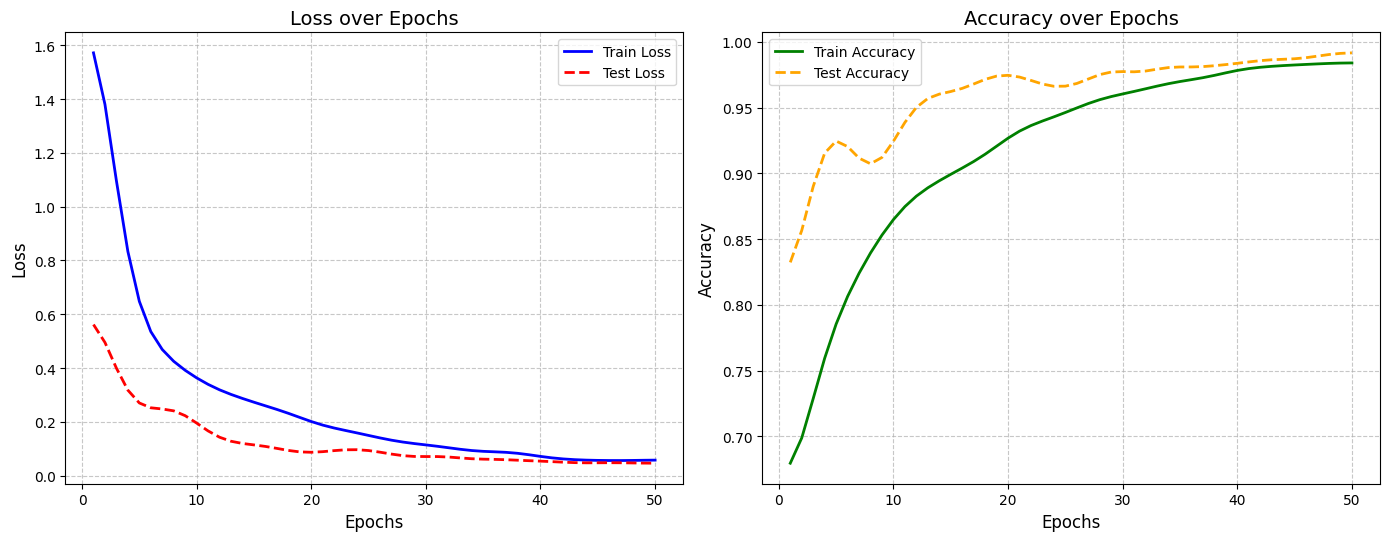

In [21]:
# Smooth Plot Function
def plot_training_progress(csv_path, save_path=None):
    # Load data from CSV
    data = pd.read_csv(csv_path)

    # Extract relevant columns
    epochs = data['Epoch']
    train_loss = data['Train Loss']
    test_loss = data['Test Loss']
    train_acc = data['Train Accuracy']  
    test_acc = data['Test Accuracy']    

    # Apply Gaussian smoothing for smoother curves
    train_loss_smooth = gaussian_filter1d(train_loss, sigma=2)
    test_loss_smooth = gaussian_filter1d(test_loss, sigma=2)
    train_acc_smooth = gaussian_filter1d(train_acc, sigma=2)
    test_acc_smooth = gaussian_filter1d(test_acc, sigma=2)

    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Loss plot
    axes[0].plot(epochs, train_loss_smooth, label='Train Loss', color='blue', linestyle='-', linewidth=2)
    axes[0].plot(epochs, test_loss_smooth, label='Test Loss', color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss over Epochs', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Accuracy plot
    axes[1].plot(epochs, train_acc_smooth, label='Train Accuracy', color='green', linestyle='-', linewidth=2)
    axes[1].plot(epochs, test_acc_smooth, label='Test Accuracy', color='orange', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy over Epochs', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Usage example
plot_training_progress('./training_results/batch_size_7/scene_4/r_training.csv', save_path=None)

In [107]:
# Save the model 
model.eval()
torch.save(model.state_dict(), result_m_dir)

In [8]:
# Load the model
loaded_model = mobilevig.mobilevig_s(num_classes=len(train_dataset.classes))
loaded_model.load_state_dict(torch.load("./training_results/batch_size_7/scene_4/m_MobileViG_s_50_epoch_0_d.pth"))
loaded_model.to(device)

C:\Users\Elang\AppData\Local\Temp\ipykernel_21544\487407036.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("./training_results/b

MobileViG(
  (stem): Stem(
    (stem): Sequential(
      (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(21, 42, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
    )
  )
  (local_backbone): ModuleList(
    (0): InvertedResidual(
      (mlp): MLP(
        (fc1): Conv2d(42, 168, kernel_size=(1, 1), stride=(1, 1))
        (act): GELU(approximate='none')
        (fc2): Conv2d(168, 42, kernel_size=(1, 1), stride=(1, 1))
        (drop): Dropout(p=0.0, inplace=False)
        (mid): Conv2d(168, 168, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=168)
        (mid_norm): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm1): BatchNorm2d(168, eps=1e-

In [18]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Oranges, save_path=None):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [19]:
# Evaluate The Model
def evaluate_model(model, dataloader, device, class_names, save_path=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_class = torch.argmax(y_pred, dim=1)
            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    class_metrics = precision_recall_fscore_support(all_labels, all_preds, labels=[0, 1, 2, 3])
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Plot confusion matrices
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cm, classes=class_names,
                          title='Confusion Matrix')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()
    
    # Confusion matrix explanation table
    cm_table_df = pd.DataFrame({
        "": ["Dark", "Green", "Light", "Medium"],
        **{f"Predicted {cls}": cm[:, i] for i, cls in enumerate(class_names)}
    })

    # Class Metrics Table
    class_metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision": class_metrics[0],
        "Recall": class_metrics[1],
        "F1 Score": class_metrics[2],
        "Support": class_metrics[3]
    })
    
    # Weighted Average Metrics Table
    weighted_avg_metrics_df = pd.DataFrame({
        "Metric": ["Precision", "Recall", "F1 Score"],
        "Score": [f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}"]
    })

    # Display DataFrame with borders
    display(HTML(cm_table_df.to_html(index=False, border=1)))
    display(HTML(class_metrics_df.to_html(index=False, border=1)))
    display(HTML(weighted_avg_metrics_df.to_html(index=False, border=1)))

    return cm_table_df, class_metrics_df, weighted_avg_metrics_df, precision, recall, f1, cm

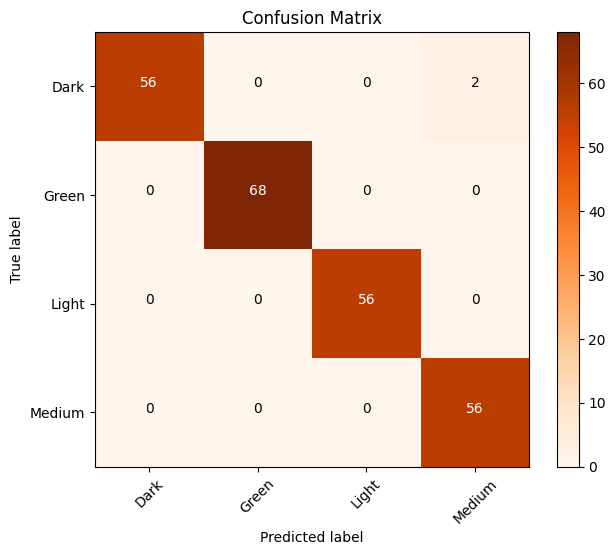

,Predicted Dark,Predicted Green,Predicted Light,Predicted Medium
Dark,56,0,0,2
Green,0,68,0,0
Light,0,0,56,0
Medium,0,0,0,56


Class,Precision,Recall,F1 Score,Support
Dark,1.000000,0.965517,0.982456,58
Green,1.000000,1.000000,1.000000,68
Light,1.000000,1.000000,1.000000,56
Medium,0.965517,1.000000,0.982456,56


Metric,Score
Precision,0.9919
Recall,0.9916
F1 Score,0.9916


In [20]:
# Display The Evaluation
cm_table_df, class_metrics_df, weighted_avg_metrics_df, precision, recall, f1, cm = evaluate_model(
    loaded_model,
    test_dataloader,
    device,
    test_dataset.classes
)

In [112]:
# Evaluate The Model with TP, FP, FN
def evaluate_model_with_misclassified_images(model, dataloader, dataset, device, class_names, save_path=None):
    model.eval()
    all_preds = []
    all_labels = []
    misclassified_images = {cls: {"TP": [], "FP": [], "FN": []} for cls in class_names}  # Store TP, FP, FN paths per class

    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_class = torch.argmax(y_pred, dim=1)

            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            # Check for misclassifications
            for i in range(len(y)):
                label = y[i].item()  # True label
                pred = y_pred_class[i].item()  # Predicted label
                img_path = dataset.samples[batch_idx * dataloader.batch_size + i][0]  # Get the image path

                # If the prediction is correct
                if label == pred:
                    misclassified_images[class_names[label]]["TP"].append(img_path)
                # If the prediction is incorrect
                else:
                    # False Positive: Predicted label is incorrect (predicted as another class)
                    if pred != label:
                        misclassified_images[class_names[pred]]["FP"].append(img_path)
                    # False Negative: True label is incorrect (predicted as another class)
                    if label != pred:
                        misclassified_images[class_names[label]]["FN"].append(img_path)

    # Display TP, FP, FN images with "tidak ada" if no TP, FP, or FN
    print("\nMisclassified Image Paths:")
    for cls, misclass_info in misclassified_images.items():
        print(f"Class '{cls}':")
        tp_paths = misclass_info["TP"] if misclass_info["TP"] else ["tidak ada"]
        fp_paths = misclass_info["FP"] if misclass_info["FP"] else ["tidak ada"]
        fn_paths = misclass_info["FN"] if misclass_info["FN"] else ["tidak ada"]

        print(f"  True Positive(s): {tp_paths}")
        print(f"  False Positive(s): {fp_paths}")
        print(f"  False Negative(s): {fn_paths}")

    return misclassified_images

In [113]:
misclassified_images = evaluate_model_with_misclassified_images(
    loaded_model, 
    test_dataloader, 
    test_dataset, 
    device, 
    test_dataset.classes
)


Misclassified Image Paths:
Class 'Dark':
  True Positive(s): ['dataset\\test\\Dark\\dark-102-_png.rf.58d87df9d18c17bb4b62448524d0acf1.jpg', 'dataset\\test\\Dark\\dark-104-_png.rf.a71e5925880cabf6fccf42419b7cc801.jpg', 'dataset\\test\\Dark\\dark-118-_png.rf.64cd33d16cad54baa35890cf2fc40c16.jpg', 'dataset\\test\\Dark\\dark-12-_png.rf.f58be211dd9c1f45b46359da6c57a735.jpg', 'dataset\\test\\Dark\\dark-120-_png.rf.a26eda1ee3329778f8bb610aa44f31da.jpg', 'dataset\\test\\Dark\\dark-130-_png.rf.5e5d3a787afdd1c44ead9e7bdf28255b.jpg', 'dataset\\test\\Dark\\dark-132-_png.rf.c2e1ed756ca6fb0bdef966b3f0295c6f.jpg', 'dataset\\test\\Dark\\dark-133-_png.rf.33ca70bb32e2f8ab0c6a51f0330414be.jpg', 'dataset\\test\\Dark\\dark-139-_png.rf.bb3fedfc9886f0ea83ff883bfa2febbe.jpg', 'dataset\\test\\Dark\\dark-142-_png.rf.12243570838e5e53544413bb3e2b612c.jpg', 'dataset\\test\\Dark\\dark-150-_png.rf.e59ced5d4f3130c3915f06dafd1c829b.jpg', 'dataset\\test\\Dark\\dark-155-_png.rf.8dd005fad352caf624649be02a2871e2.jpg', 'd

In [114]:
def display_misclassified_images(misclassified_images, ncols=3, max_images=30):
    """
    Tampilkan gambar FP & FN (tidak menampilkan TP).
    
    Args:
        misclassified_images : dict hasil dari evaluate_model_with_misclassified_images
        ncols                : jumlah kolom grid
        max_images           : maksimal jumlah gambar yang ditampilkan
    """
    all_images = []
    all_labels = []
    
    for cls, misclass_info in misclassified_images.items():
        for label_type, image_paths in misclass_info.items():
            if label_type in ["FP", "FN"]:
                for img_path in image_paths:
                    if len(all_images) >= max_images:  # batasi jumlah gambar
                        break
                    try:
                        img = Image.open(img_path).convert("RGB")
                        all_images.append(img)
                        all_labels.append(f"{label_type} - {cls}")
                    except Exception as e:
                        print(f"[ERROR] gagal buka {img_path}: {e}")
    
    if not all_images:
        print("⚠️ Tidak ada gambar FP/FN ditemukan.")
        return
    
    nrows = (len(all_images) // ncols) + 1
    plt.figure(figsize=(ncols * 5, nrows * 4))
    
    for i in range(len(all_images)):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(all_images[i])
        plt.title(all_labels[i], fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


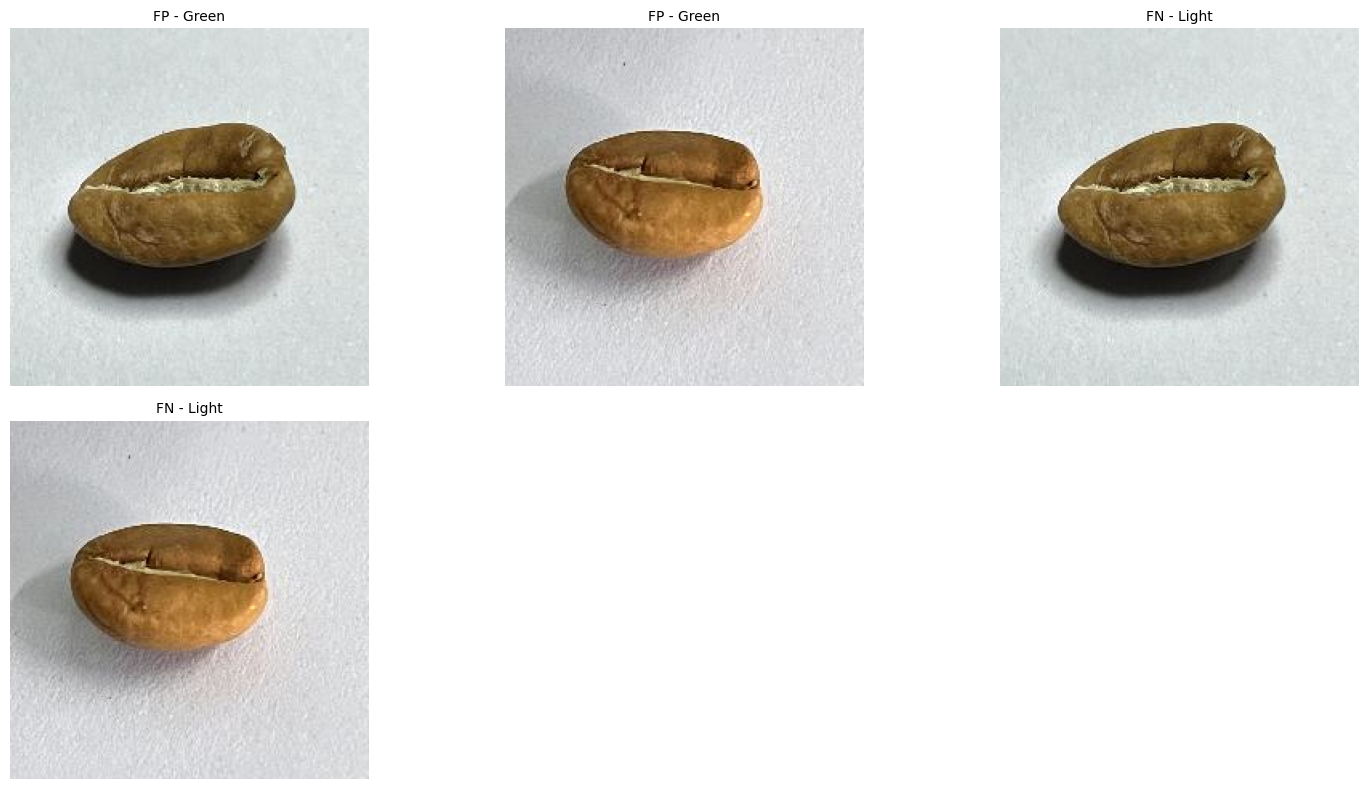

In [115]:
# Tampilkan maksimal 30 gambar salah prediksi
display_misclassified_images(misclassified_images, ncols=3, max_images=30)

In [64]:
# Fungsi untuk menampilkan gambar FP dan FN (tidak menampilkan TP)
def display_misclassified_images(misclassified_images, ncols=3):
    plt.figure(figsize=(15, 5))
    
    # Loop untuk setiap kelas dan gambar False Positive / False Negative
    all_images = []
    all_labels = []
    
    for cls, misclass_info in misclassified_images.items():
        # Hanya untuk FP dan FN, tidak untuk TP
        for label_type, image_paths in misclass_info.items():
            if label_type in ["FP", "FN"]:  # Hanya ambil FP dan FN
                for img_path in image_paths:
                    img = Image.open(img_path)
                    all_images.append(img)
                    all_labels.append(f"{label_type} - {cls}")
    
    # Menentukan jumlah baris dan kolom untuk grid tampilan
    nrows = (len(all_images) // ncols) + 1
    for i in range(len(all_images)):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(all_images[i])
        plt.title(all_labels[i])
        plt.axis('off')  # Tidak menampilkan sumbu
    
    plt.tight_layout()
    plt.show()

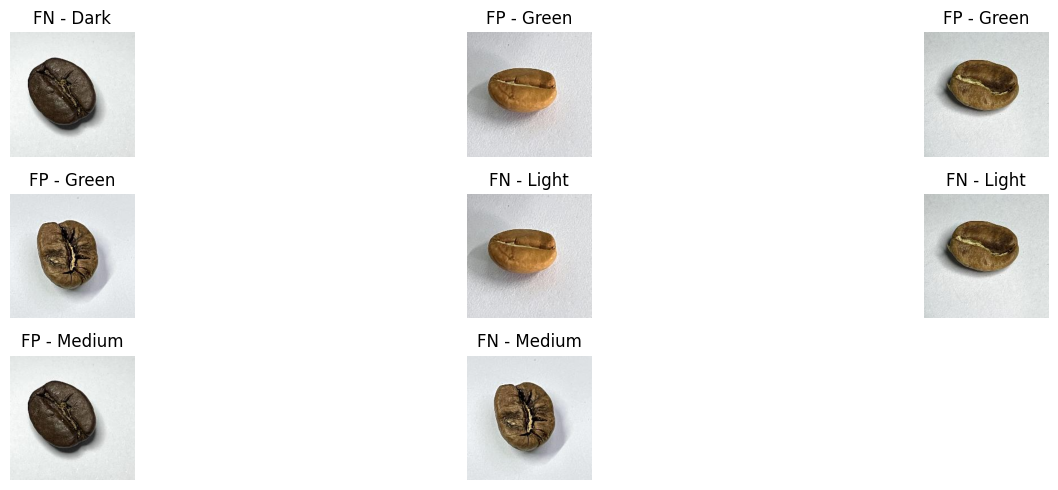

In [65]:
# Menampilkan gambar yang salah prediksi
display_misclassified_images(misclassified_images, ncols=3)

In [116]:
# Function to save evaluation results to CSV in a specified folder
def save_evaluation_results_to_csv(class_metrics_df, weighted_avg_metrics_df, folder_path):
    # Create the folder if it does not exist
    os.makedirs(folder_path, exist_ok=True)
    
    # Save the DataFrames to CSV files in the specified folder
    cm_table_df.to_csv(os.path.join(folder_path, 'cm_table.csv'), index=False)
    class_metrics_df.to_csv(os.path.join(folder_path, 'e_class_f1_score.csv'), index=False)
    weighted_avg_metrics_df.to_csv(os.path.join(folder_path, 'e_avg_f1_score.csv'), index=False)
    
    print(f"Evaluation results saved to CSV files in folder: {folder_path}")

In [117]:
# Save DataFrames to CSV
save_evaluation_results_to_csv(class_metrics_df, weighted_avg_metrics_df, result_e_dir)

Evaluation results saved to CSV files in folder: ./training_results/batch_size_7/scene_6


In [23]:
# Prediction function
def predict_image(model, img_path, transform, class_names):
    model.eval()
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
    probabilities = torch.softmax(output, dim=1)[0] * 100
    _, predicted_idx = torch.max(output, 1)
    predicted_class = class_names[predicted_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class}')
    plt.show()

    # Ensure the lengths of class_names and probabilities match
    probabilities = probabilities[:len(class_names)]

    # Create DataFrame
    confidence_df = pd.DataFrame({
        "Class": class_names,
        "Confidence": [f"{prob:.2f}%" for prob in probabilities.cpu().numpy()]
    }).sort_values(by="Confidence", ascending=False)

    # Display DataFrame with borders
    display(HTML(confidence_df.to_html(index=False, border=1)))

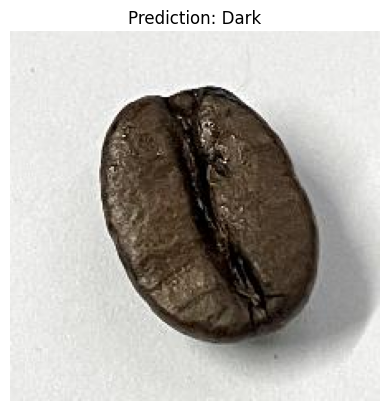

Class,Confidence
Dark,99.98%
Medium,0.01%
Green,0.00%
Light,0.00%


In [26]:
# Example usage for prediction
test_img_path = "dataset/test/Dark/dark-47-_png.rf.3efd81e2511f462da92369c6eec6d658.jpg"  # Replace with your own image path
predict_image(loaded_model, test_img_path, test_transforms, train_dataset.classes)